In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
train = pd.read_csv("/content/drive/My Drive/hacklive2_train.csv", encoding="utf-8")
test = pd.read_csv("/content/drive/My Drive/hacklive2_test.csv", encoding="utf-8")
submission = pd.read_csv("/content/drive/My Drive/hacklive2_submission.csv", encoding="utf-8")
train.head()

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,country_code,likes
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,24.0,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",351430.0,298.0,900.0,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,CA,2351.0
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,ABS-CBN Entertainment,24.0,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",461508.0,74.0,314.0,Vice Ganda notices Bela Padilla's sudden chang...,CA,3264.0
2,1856,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n ಕ್...,SANDALWOOD REVIEWS,24.0,2018-03-26,"challenging star darshan latest news|""challeng...",40205.0,150.0,100.0,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ ಕ್ಲ...,IN,580.0
3,22618,Havana - swing cover | dodie feat. FLASHBACK,doddleoddle,10.0,2018-02-21,"havana|""cover""|""a capella""|""swing""|""dodie""|""fl...",509726.0,847.0,4536.0,Hi hi hi! here's our vid on FLASHBACK's channe...,GB,82773.0
4,74074,MUMMY NE NI KEHTA - 2 FT. 102 NOT OUT| DUDE S...,Dude Seriously,23.0,2018-05-10,"dude|""seriously""|""friends""|""fun""|""gujarati""|""h...",74311.0,69.0,161.0,BOOK YOUR TICKETS HERE: https://goo.gl/QxdSyg...,IN,3557.0


In [15]:
ID_COL, TARGET_COL = 'video_id', 'likes'
num_cols = ['views','dislikes','comment_count']
cat_cols = ['category_id', 'country_code', 'channel_title']

In [16]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def rmsle(y_true, y_pred):
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

def av_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

In [17]:
def combine_df(train, test):
  df = pd.concat([train, test], axis=0).reset_index(drop=True)
  features = [x for x in df.columns if x not in [ID_COL, TARGET_COL]]
  df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x : np.log1p(x))

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

In [18]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):
  submission[TARGET_COL] = preds_test
  submission.to_csv(file_name, index = False)

  from google.colab import files
  files.download(file_name)

In [19]:
from sklearn.model_selection import StratifiedKFold
def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train_pro))
  preds = np.zeros((len(test_pro)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    X_test = test[features]
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:25][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

In [20]:
df, features = combine_df(train,test)

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[cat_cols] = df[cat_cols].apply(lambda x: le.fit_transform(x))

# Feature Engineering


In [24]:
df['publish_date'] = pd.to_datetime(df['publish_date'],format = "%Y-%m-%d")
df['first_video'] = (df['publish_date'] - df['publish_date'].min()).dt.days

df['day_of_week'] = df['publish_date'].dt.dayofweek
df['month_of_publish'] = df['publish_date'].dt.month
df['year_of_publish'] = df['publish_date'].dt.year

df['channel_title_num_videos'] = df['channel_title'].map(df['channel_title'].value_counts())
df['publish_date_num_videos'] = df['publish_date'].map(df['publish_date'].value_counts())
df['category_counts'] = df['category_id'].map(df['category_id'].value_counts())
df['channel_in_n_countries'] = df.groupby('channel_title')['country_code'].transform('nunique')

In [25]:
df['channel_title_mean_views'] = df.groupby('channel_title')['views'].transform('mean')
df['channel_title_max_views'] = df.groupby('channel_title')['views'].transform('max')
df['channel_title_min_views'] = df.groupby('channel_title')['views'].transform('min')
df['channel_title_median_views'] = df.groupby('channel_title')['views'].transform('median')
df['channel_title_total_views'] = df.groupby('channel_title')['views'].transform('sum')

df['channel_title_mean_comments'] = df.groupby('channel_title')['comment_count'].transform('mean')
df['channel_title_max_comments'] = df.groupby('channel_title')['comment_count'].transform('max')
df['channel_title_min_comments'] = df.groupby('channel_title')['comment_count'].transform('min')
df['channel_title_median_comments'] = df.groupby('channel_title')['comment_count'].transform('median')
df['channel_title_total_comments'] = df.groupby('channel_title')['comment_count'].transform('sum')

df['channel_title_mean_dislikes'] = df.groupby('channel_title')['dislikes'].transform('mean')
df['channel_title_max_dislikes'] = df.groupby('channel_title')['dislikes'].transform('max')
df['channel_title_min_dislikes'] = df.groupby('channel_title')['dislikes'].transform('min')
df['channel_title_median_dislikes'] = df.groupby('channel_title')['dislikes'].transform('median')
df['channel_title_total_dislikes'] = df.groupby('channel_title')['dislikes'].transform('sum')

In [26]:
df['title_length'] = df['title'].apply(lambda x : len(x))
df['tag_length'] = df['tags'].apply(lambda x : len(x))
df['description_length'] = df['description'].apply(lambda x : len(x))

In [30]:
df['total_views_per_month'] = df.groupby('month_of_publish')['views'].transform('sum')
df['mean_views_per_month'] = df.groupby('month_of_publish')['views'].transform('mean') 

df['total_comments_per_month'] = df.groupby('month_of_publish')['comment_count'].transform('sum')
df['mean_comments_per_month'] = df.groupby('month_of_publish')['comment_count'].transform('mean') 

df['total_dislikes_per_month'] = df.groupby('month_of_publish')['dislikes'].transform('sum')
df['mean_dislikes_per_month'] = df.groupby('month_of_publish')['dislikes'].transform('mean') 

df['total_views_per_weekday'] = df.groupby('day_of_week')['views'].transform('sum')
df['mean_views_per_weekday'] = df.groupby('day_of_week')['views'].transform('mean') 

df['total_comments_per_weekday'] = df.groupby('day_of_week')['comment_count'].transform('sum')
df['mean_comments_per_weekday'] = df.groupby('day_of_week')['comment_count'].transform('mean') 

df['total_dislikes_per_weekday'] = df.groupby('day_of_week')['dislikes'].transform('sum')
df['mean_dislikes_per_weekday'] = df.groupby('day_of_week')['dislikes'].transform('mean') 

In [31]:
df['total_views_per_category'] = df.groupby('category_id')['views'].transform('sum')
df['mean_views_per_category'] = df.groupby('category_id')['views'].transform('mean')

df['total_comments_per_category'] = df.groupby('category_id')['comment_count'].transform('sum')
df['mean_comments_per_category'] = df.groupby('category_id')['comment_count'].transform('mean')

df['total_dislikes_per_category'] = df.groupby('category_id')['dislikes'].transform('sum')
df['mean_dislikes_per_category'] = df.groupby('category_id')['dislikes'].transform('mean')

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
TOP_N_WORDS = 50

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts = vec.fit_transform(df['description']).toarray()

c = 'description'
txt_fts_desc = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_desc] = txt_to_fts

In [28]:
txt_to_fts = vec.fit_transform(df['title']).toarray()
c = 'title'
txt_fts_title = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_title] = txt_to_fts

In [29]:
txt_to_fts = vec.fit_transform(df['tags']).toarray()
c = 'tags'
txt_fts_tags = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_tags] = txt_to_fts

In [32]:
train_pro, test_pro, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.491963
[600]	valid_0's rmse: 0.478629
[900]	valid_0's rmse: 0.474605
[1200]	valid_0's rmse: 0.472494
[1500]	valid_0's rmse: 0.471631
[1800]	valid_0's rmse: 0.471025
[2100]	valid_0's rmse: 0.470514
[2400]	valid_0's rmse: 0.470228
[2700]	valid_0's rmse: 0.470126
[3000]	valid_0's rmse: 0.469962
[3300]	valid_0's rmse: 0.469911
[3600]	valid_0's rmse: 0.469885
Early stopping, best iteration is:
[3469]	valid_0's rmse: 0.469843

AV metric score for validation set is 469.8427975803013

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.483862
[600]	valid_0's rmse: 0.470914
[900]	valid_0's rmse: 0.466999
[1200]	valid_0's rmse: 0.464954
[1500]	valid_0's rmse: 0.463963
[1800]	valid_0's rmse: 0.463337
[2100]	valid_0's rmse: 0.463272
[2400]	valid_0's rmse: 0.462934
[2700]	valid_0's rmse: 0.462873
Early stoppi

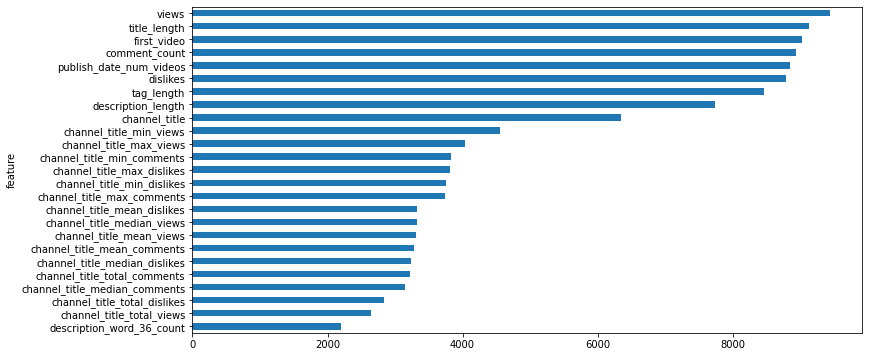

In [33]:
from lightgbm import LGBMRegressor
clf = LGBMRegressor(
 n_estimators = 5000,
 colsample_bytree = 0.65,
 bagging_fraction = 0.91,
 bagging_freq = 3,
 learning_rate = 0.05,
 max_depth = 16,
 min_data_in_leaf = 10,
 num_leaves = 80,
 reg_alpha = 0.76,
 reg_lambda = 0.85,
 metric = 'None',)
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf, fit_params, train_pro, test_pro, cat_num_cols)

In [34]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 'finalmodel.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>